# Image Classification With Transfer Learning Using Keras

# Task 1: Importing Libraries

In [ ]:
import tensorflow as tf
import tarfile
import urllib
import os
import numpy as np
import pets

from matplotlib import pyplot as plt
%matplotlib inline

data_dir = 'data/'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

# Task 2: Cats vs Dogs Dataset

In [ ]:
pets.download_and_extract('data', '.')

In [ ]:

class_to_index = {'cat': 0, 'dog': 1}
index_to_class = {0: 'cat', 1: 'dog'}

train_annot, count_train = pets.cats_vs_dogs_annotations('annotations/trainval.txt')
test_annot, count_test = pets.cats_vs_dogs_annotations('annotations/test.txt')

# Task 3: Get Random Batch

In [ ]:
image_dir = 'images'

def get_random_batch(annot, batch_size):
    all_keys = list(annot.keys())
    total_examples = len(all_keys)

    indices = np.random.choice(range(total_examples), batch_size)
    x = np.zeros((batch_size, 128, 128, 3))
    y = np.zeros((batch_size, 1))
    images = []

    for i, idx in enumerate(indices):
        image_path = os.path.join(image_dir, all_keys[idx])
        image = tf.keras.preprocessing.image.load_img(image_path, target_size = (128, 128))
        arr = tf.keras.preprocessing.image.img_to_array(image)
        arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr)
        arr = np.expand_dims(arr, axis = 0)
        x[i] = arr
        y[i] = class_to_index[annot[all_keys[idx]]]
        images.append(image)

    return x, y, images

In [ ]:
x, y, images = get_random_batch(train_annot, batch_size = 64)
pets.display_examples(x, y, y, images, index_to_class).show()

# Task 4: Create Model

In [ ]:
mnet = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, pooling='avg', weights = 'imagenet', input_shape= (128, 128, 3))

mnet.summary()

In [22]:
def create_model():
    model = tf.keras.models.Sequential([
        mnet,
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])

    model.layers[0].trainable = False

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01), loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model

model = create_model()

# Task 5: Model Training

In [24]:
def data_generator(batch_size, annot):
    while True:
        x, y, _ = get_random_batch(annot, batch_size=batch_size)
        yield (x, y)

In [17]:
batch_size = 64
steps_per_epoch = count_train // batch_size
validation_steps = count_test // batch_size
epochs = 2

In [25]:
%%time
history = model.fit(data_generator(batch_size, train_annot), validation_data = data_generator(batch_size, test_annot), steps_per_epoch = steps_per_epoch, validation_steps = validation_steps, epochs = epochs)

Epoch 1/2


57/57 [==============================] - 94s 2s/step - loss: 0.1513 - accuracy: 0.9444 - val_loss: 0.0916 - val_accuracy: 0.9715
Epoch 2/2
57/57 [==============================] - 61s 1s/step - loss: 0.0900 - accuracy: 0.9723 - val_loss: 0.0633 - val_accuracy: 0.9836
CPU times: total: 41.9 s
Wall time: 2min 36s


# Task 6: Predictions

In [26]:
x, y, images = get_random_batch(test_annot, batch_size = 64)

preds = model.predict(x)

2/2 [==============================] - 2s 184ms/step


Displaying first 8 examples..


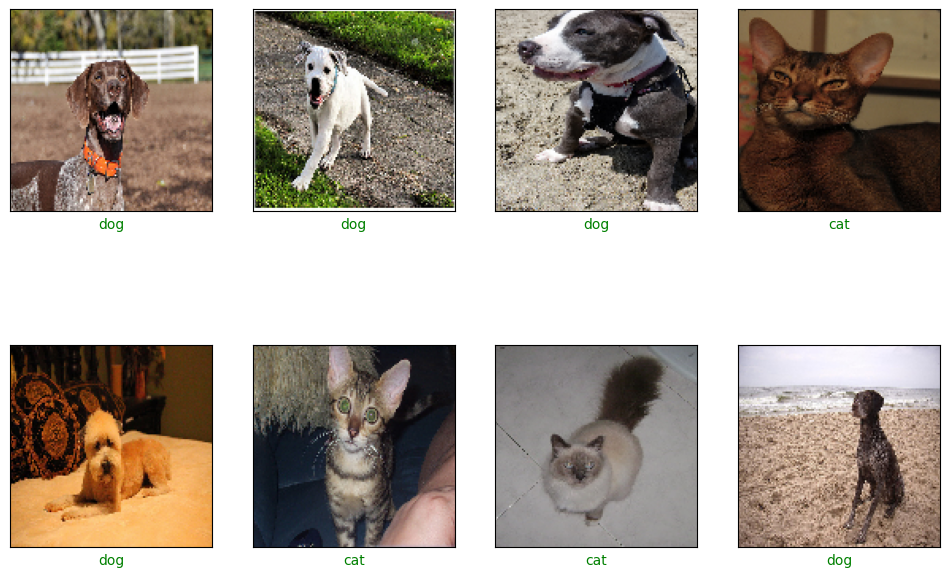

In [28]:
pets.display_examples(x, y ,preds, images, index_to_class).show()